Мгновенное выполнение Tensorflow - это среда императивного программирования, которая выполняет операции немедленно, без построения графов: операции возвращают конкретные значения вместо построения вычислительного графа для последующего запуска. Это делает проце знакомство с Tensorflow и дебаггинг моделей, а так же уменьшает количество бойллерплет-кода. 
Чтобы пройти этот гайд, просто запускайте сэмплы кода ниже в интерактивном интерпретаторе питона.

Мгноверрное выполнение - это гибкая платформа машинного обучения для исследований и эксперементов, предоставляющая:

- Интуитивно понятный интерфейс. 
Структурируйте свой код естественным образом и используйте структуры данных Python. Быстро перебирайте небольшие модели и небольшие данные.
- Упрощенная отладка.
Вызовите операторы напрямую, чтобы проверить работающие модели и протестировать изменения. Используйте стандартные инструменты отладки Python для немедленного сообщения об ошибках.
- Естественный поток управления.
Используйте поток управления Python вместо потока управления графом, что упрощает спецификацию динамических моделей. 

Мгновенное выполнение поддерживает большинство операций Tensorflow с GPU-ускорением.

In [1]:
import os
import tensorflow as tf
import cProfile

In [3]:
tf.executing_eagerly()

True

In [4]:
x = [[2.]]
m = tf.matmul(x, x)
print("hello, {}".format(m))

hello, [[4.]]


Включение немедленного выполнения изменяет поведение операций TensorFlow - теперь они немедленно вычисляют и возвращают  значения в Python. Объекты tf.Tensor ссылаются на конкретные значения вместо символических указателей на узлы в вычислительном графе. Поскольку нет вычислительного графа, который можно было бы построить и запустить позже в сеансе, легко проверить результаты с помощью print () или отладчика. Оценка, печать и проверка значений тензора не прерывают процесс вычисления градиентов.

Немедленное выполнение прекрасно работает с NumPy. Операции NumPy принимают аргументы tf.Tensor. Операции TensorFlow tf.math преобразуют объекты Python и массивы NumPy в объекты tf.Tensor. Метод tf.Tensor.numpy возвращает значение объекта в виде массива NumPy ndarray.

In [5]:
a = tf.constant([[1, 2],
                 [3, 4]])
print(a)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [6]:
# Broadcasting support
b = tf.add(a, 1)
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [7]:
# Operator overloading is supported
print(a * b)

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [8]:
# Use NumPy values
import numpy as np

c = np.multiply(a, b)
print(c)

[[ 2  6]
 [12 20]]


In [10]:
# Obtain numpy value from a tensor:
print(a.numpy())

[[1 2]
 [3 4]]


Динамический поток управления

Основным преимуществом немедленного выполнения является то, что все функции основного языка доступны во время работы вашей модели. Можно, например, легко написать fizzbuzz:

In [11]:
def fizzbuzz(max_num):
    counter = tf.constant(0)
    max_num = tf.convert_to_tensor(max_num)
    for num in range(1, max_num.numpy()+1):
        num = tf.constant(num)
        if int(num % 3) == 0 and int(num % 5) == 0:
            print('FizzBuzz')
        elif int(num % 3) == 0:
            print('Fizz')
        elif int(num % 5) == 0:
            print('Buzz')
        else:
            print(num.numpy())
        counter += 1

In [12]:
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


Мгновенное обучение.
Вычислительные градиенты

Автоматическое дифференцирование полезно для реализации алгоритмов машинного обучения(таких как обратное распространение) в обучении нейронных сетей. Во время мгновенного выполнения используйте tf.GradientTape для последующего отслеживания операций вычисления градиентов.

Вы можете использовать tf.GradientTape для обучения и/или вычисления градиентов в в режиме "мгновенности". Это особенно полезно для сложных тренировочных циклов.

Поскольку во время каждого вызова могут происходить разные операции, все операции прямого прохода записываются на «ленту». Чтобы вычислить градиент, воспроизведите ленту в обратном направлении, а затем сбросьте ее. Конкретный tf.GradientTape может вычислять только один градиент; последующие вызовы вызывают runtime error.

In [15]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
    loss = w * w

grad = tape.gradient(loss, w)
print(grad)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


Обучение модели.

В следующем примере создается многослойная модель, которая классифицирует стандартные рукописные цифры MNIST. Он демонстрирует оптимизатор и API слоев для построения обучаемых графов в среде активного выполнения.

In [16]:
# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

11493376/11490434 [==============================] - 1s 0us/step


In [17]:
# Build the model
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu',
                         input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

In [18]:
for images,labels in dataset.take(1):
    print("Logits: ", mnist_model(images[0:1]).numpy())

Logits:  [[-0.03673956  0.01568081 -0.02212567  0.00119896  0.00864087 -0.00465332
  -0.06325376 -0.01802111 -0.01361521  0.014974  ]]


Хотя модели keras имеют встроенный цикл обучения (с использованием метода fit), иногда вам требуется дополнительная настройка. Вот пример цикла обучения, реализованного с помощью eager:

In [19]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

In [20]:
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = mnist_model(images, training=True)

        # Add asserts to check the shape of the output.
        tf.debugging.assert_equal(logits.shape, (32, 10))

        loss_value = loss_object(labels, logits)

    loss_history.append(loss_value.numpy().mean())
    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [21]:
def train(epochs):
    for epoch in range(epochs):
        for (batch, (images, labels)) in enumerate(dataset):
            train_step(images, labels)
        print ('Epoch {} finished'.format(epoch))

In [22]:
train(epochs = 3)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished


Text(0, 0.5, 'Loss [entropy]')

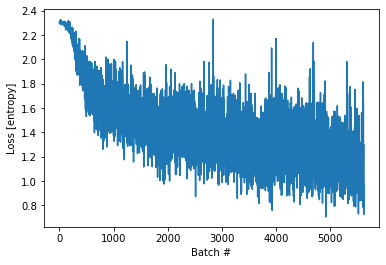

In [23]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')